# Data Handling and Preparation

## Import Python Packages

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import  functional as F
import torch.optim as optim

from sklearn.metrics import *

## Data Processing

In [36]:
# Load the datasets
x_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')

x_train_df = pd.DataFrame(x_train, columns=[f"x{i}" for i in range(1, 112)])
y_train_df = pd.DataFrame(y_train, columns=[f"y{i}" for i in range(1, 12)])
x_test_df = pd.DataFrame(X_test, columns=[f"x{i}" for i in range(1, 112)])

# Check the shape of the datasets
print(x_train.shape)
print(X_test.shape)
print(y_train.shape)

(1000, 111)
(700, 111)
(1000, 11)


In [37]:
np.unique(y_train)

array([0, 1])

In [38]:
unique_counts = {}
for column in y_train_df.columns:
    unique_counts[column] = y_train_df[column].value_counts().to_dict()

# 打印结果
for label, counts in unique_counts.items():
    print(f"Counts for label {label}: {counts}")

Counts for label y1: {0: 720, 1: 280}
Counts for label y2: {0: 787, 1: 213}
Counts for label y3: {0: 779, 1: 221}
Counts for label y4: {0: 769, 1: 231}
Counts for label y5: {0: 766, 1: 234}
Counts for label y6: {0: 730, 1: 270}
Counts for label y7: {0: 780, 1: 220}
Counts for label y8: {0: 756, 1: 244}
Counts for label y9: {0: 606, 1: 394}
Counts for label y10: {0: 727, 1: 273}
Counts for label y11: {0: 737, 1: 263}


In [39]:
print(f'There are {x_train_df.isnull().any().sum()} columns in train dataset with missing values.')
print(f'There are {x_train_df.isnull().any(axis=1).sum()} rows in train dataset with missing values.')

There are 109 columns in train dataset with missing values.
There are 1000 rows in train dataset with missing values.


## Remove Rows/Columns with More Than 40% Missing Values

In [40]:
have_null_fea_dict = (x_train_df.isnull().sum()/len(x_train_df)).to_dict()
fea_null_moreThan40 = {}
for key, value in have_null_fea_dict.items():
    if value > 0.4:
        fea_null_moreThan40[key] = value
print(f"missing value in column more than 40%:")
print(fea_null_moreThan40)

missing value in column more than 40%:
{'x7': 0.963, 'x34': 0.644, 'x35': 0.644, 'x88': 0.998}


In [41]:
# 计算每行的缺失值比例
have_null_fea_row_dict = (x_train_df.isnull().sum(
    axis=1)/x_train_df.shape[1]).to_dict()

# 找出缺失值超过40%的行
fea_null_moreThan40_row = {}
for key, value in have_null_fea_row_dict.items():
    if value > 0.4:
        fea_null_moreThan40_row[key] = value
print(f"missing value in column more than 40%:")
print(fea_null_moreThan40_row)

missing value in column more than 40%:
{21: 0.5405405405405406, 711: 0.43243243243243246, 849: 0.4864864864864865}


In [42]:
x_train_df.drop(columns=fea_null_moreThan40, inplace=True)
x_train_df.drop(fea_null_moreThan40_row.keys(), inplace=True)
y_train_df.drop(fea_null_moreThan40_row.keys(), inplace=True)
x_test_df.drop(columns=fea_null_moreThan40, inplace=True)
x_train_df.shape, y_train_df.shape, x_test_df.shape

((997, 107), (997, 11), (700, 107))

##  Imputation of Missing Values and Standardization

In [43]:
# 缺失值填充为中位数

num_cols = x_train_df.columns
# num_cols
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler()) #均值-标准差归一化
num_steps = [num_si_step, num_ss_step]

num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=num_transformers)

x_all = ct.fit_transform(x_train_df)
x_all.shape

(997, 107)

In [44]:
y_all = y_train_df.values
y_all.shape

(997, 11)

In [45]:
# 预处理测试数据
x_predict = ct.transform(x_test_df)
x_predict.shape

(700, 107)

## Splitting into Training and Testing Sets

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.25)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((747, 107), (250, 107), (747, 11), (250, 11))

## label one train dataset

In [47]:
x_train, x_test, y_train, y_test = x_train, x_test, y_train[:,0], y_test[:,0]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((747, 107), (250, 107), (747,), (250,))

## Prepare PyTorch Dataset and DataLoader

In [48]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


In [49]:
# dataset

from torch.utils.data import TensorDataset

train_ds = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
# train_all_ds = TensorDataset(torch.tensor(x_all).float(), torch.tensor(y_all).long())
test_ds = TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())

In [50]:
# dataloader

batch_size = 12
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# train_all_dl = DataLoader(train_all_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [51]:
# check shape

for b_x, b_y in test_dl:
  print(b_x.shape)
  print(b_y.shape)
  break

torch.Size([12, 107])
torch.Size([12])


In [52]:
b_y

tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

# Construct Training and Evaluation Functions

In [53]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # loss = loss_fn(pred, y.type(torch.float))
        # batch_loss_value = loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [54]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n  Avg loss: {test_loss:>8f} \n")
    return test_loss

In [55]:
dim_num = x_all.shape[1]
dim_num

107

In [56]:
n_classes = 2

# CNN--11 Single-Label Classification Task

In [65]:
class CNNMblock(nn.Module):
    def __init__(self,):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.cnn = nn.Conv1d(dim_num,8,1)
        self.out = nn.Linear(8, n_classes)
        self.flatten = nn.Flatten()
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        # x = self.nor(x)
        x = x.view(-1,dim_num,1)
        # print(x.shape)
        x= self.cnn(x)
        x = self.flatten(x)
        x = self.out(x)
        x = self.sigm(x)

        return x

# 定义评估函数
def evaluate(model, dataloader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = np.argmax(outputs.cpu().numpy(), axis=1)
            y_true.append(labels.cpu().numpy())
            y_pred.append(predictions)
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, f1, y_true, y_pred

import torch
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

------ it is the label ------  0
Done!
accuracy: 0.74
F1 Score: 0.6783622828784118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85       151
           1       0.38      0.10      0.16        49

    accuracy                           0.74       200
   macro avg       0.57      0.52      0.50       200
weighted avg       0.67      0.74      0.68       200

------ it is the label ------  1
Done!
accuracy: 0.755
F1 Score: 0.6914203045114894
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       159
           1       0.10      0.02      0.04        41

    accuracy                           0.76       200
   macro avg       0.44      0.48      0.45       200
weighted avg       0.65      0.76      0.69       200

------ it is the label ------  2
Done!
accuracy: 0.77
F1 Score: 0.6829943502824858
              precision    recall  f1-score   support

           0       0.78      0.98      0.

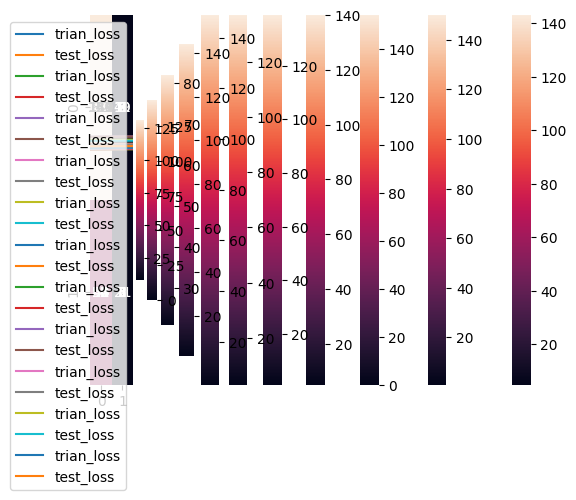

In [66]:
def train_one_dataset(index):
  """## label one train dataset"""
  x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2,random_state=123)
  x_train, x_test, y_train, y_test = x_train, x_test, y_train[:,index], y_test[:,index]
  # x_train.shape, x_test.shape, y_train.shape, y_test.shape


  """## Prepare PyTorch Dataset and DataLoader"""
  # dataset
  train_ds = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
  train_all_ds = TensorDataset(torch.tensor(x_all).float(), torch.tensor(y_all).long())
  test_ds = TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())

  # dataloader

  batch_size = 12
  train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  # train_all_dl = DataLoader(train_all_ds, batch_size=batch_size, shuffle=True)
  test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

  # check shape

  for b_x, b_y in test_dl:
    # print(b_x.shape)
    # print(b_y.shape)
    break

  """# (1) CNN model (SGD optimizer)

  ## Build Model
  """

  cnn_model = CNNMblock().to(device)


  cnn_model(b_x.to(device)).shape

  """## Optimizer"""

  # loss_fn = nn.BCELoss()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(cnn_model.parameters(), lr=1e-3)

  """## Training and Evaluation"""

  epochs = 100
  train_loss_list = []
  test_loss_list = []

  for t in range(epochs):
      # print(f"Epoch {t+1}\n-------------------------------")
      train(train_dl, cnn_model, loss_fn, optimizer)
      train_loss = test(train_dl, cnn_model, loss_fn)
      test_loss= test(test_dl, cnn_model, loss_fn)
      train_loss_list.append(train_loss)
      test_loss_list.append(test_loss)

  print("Done!")

  # 损失函数图像

  plt.plot(train_loss_list, label='trian_loss')
  plt.plot(test_loss_list, label = 'test_loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend(loc='upper right')

  """## Analysis

  ### accuracy and F1
  """



  # 计算评估指标
  accuracy, f1, y_true, y_pred = evaluate(cnn_model, test_dl)

  print("accuracy:", accuracy)
  print("F1 Score:", f1)

  """### classification report"""


  print(classification_report(y_true, y_pred))

  """### Confusion Matrix"""


  cnf_matrix = confusion_matrix(y_true, y_pred)
  cnf_matrix

  sns.heatmap(cnf_matrix, annot=True, fmt='g')
  return accuracy, f1, y_true, y_pred, cnf_matrix, cnn_model

# training
result_list = []
model_list = []

for index in range(11):
  print('------ it is the label ------ ',index)
  accuracy, f1, y_true, y_pred, cnf_matrix, trained_model= train_one_dataset(index)
  result_list.append([accuracy, f1, y_true, y_pred, cnf_matrix])
  model_list.append(trained_model)  # 将训练好的模型添加到列表中

pd_dataf = pd.DataFrame(result_list, columns=['accuracy', 'f1', 'y_true', 'y_pred', 'cnf_matrix'])
pd_dataf.to_csv('result.csv', index=False)


In [67]:
pd_dataf

,accuracy,f1,y_true,y_pred,cnf_matrix
0,0.740,0.678362,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[143, 8], [44, 5]]"
1,0.755,0.691420,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[150, 9], [40, 1]]"
2,0.770,0.682994,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[154, 3], [43, 0]]"
3,0.725,0.665327,"[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[140, 10], [45, 5]]"
4,0.700,0.656538,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[139, 19], [41, 1]]"
5,0.700,0.619760,"[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[137, 8], [52, 3]]"
6,0.760,0.692486,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[149, 6], [42, 3]]"
7,0.730,0.668149,"[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[[144, 11], [43, 2]]"
8,0.515,0.502768,"[0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, ...","[[82, 41], [56, 21]]"
9,0.720,0.611163,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[144, 2], [54, 0]]"


In [68]:
pd_dataf['f1'].mean()

0.6450990694910334

In [69]:
pd_dataf['accuracy'].mean()

0.71

# Prediction

In [70]:
# 预测函数定义
one_predict = torch.tensor(x_predict).float()
def predict_one(trained_model):
  with torch.no_grad():
    trained_model.eval()
    one_predict_label = trained_model(one_predict)
    predictions = np.argmax(one_predict_label.cpu().numpy(), axis=1)
  return predictions

In [71]:
predict_list = []
for index in range(11):
  predictions = predict_one(model_list[index])
  predict_list.append(predictions)

# 创建行列名列表
row_names = ['task' + str(i) for i in range(1, 12)]
column_names = list(range(1, 701))

pd_predict = pd.DataFrame(np.stack(predict_list,axis=0), index=row_names, columns=column_names)
pd_predict.to_csv('predict.csv', index=False)
pd_predict

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700
task1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0